# Models d'Inteligència Artifial: Practica 6

En aquesta tasca implementareu un generador de text basat en un GPT en miniatura. Així veurem com és el codi d'un transformer com el descrit als apunts.

Prendreu com a base l'exemple https://keras.io/examples/generative/text_generation_with_miniature_gpt/, i lliurareu el vostre quadern Colab (URL o document, com volgueu) amb les explicacions i modificacions que es demanen a continuació.

Realitzau les passes següents i responeu les qüestions que es plantegen aquí dins requadres de text dins el vostre quadern Colab.

## 1. Setup. Possiblement necessitareu instal·lar la darrera versió de keras.

In [10]:
# instalar keras en cas de que no el tenguem
# %pip install keras # Commented out for brevity
# instalar la darrera versió
# %pip install keras --upgrade # Commented out for brevity

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers # This line was missing, added to import the layers module explicitly
from keras import ops
from keras.layers import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

## 2. Implementació d'un bloc transformer com a capa. Què significa que la màscara d'atenció sigui causal?

In [11]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = ops.arange(n_dest)[:, None]
    j = ops.arange(n_src)
    m = i >= j - n_src + n_dest
    mask = ops.cast(m, dtype)
    mask = ops.reshape(mask, [1, n_dest, n_src])
    mult = ops.concatenate(
        [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])], 0
    )
    return ops.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


Que la màscara d'atenció sigui casual és important perquè asegudar que la informació vagi de tokens passats a futurs i no de manera contraria. Crea una matriu triangular on cada possició només pot observar la possició previa, el que és crucial per a models regressius com GPT. Això preven que el model fagi trampes durant el entrenament observant els tokens futurs que és el que es suposa que se ha de predir.

## 3. Implementació de les capes d'embedding.

In [12]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## 4.  Implementació del GPT en miniatura. Quines funcions implementades als punts anteriors s'invoquen ara?

In [13]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="int32")
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam",
        loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model


Aquesta funció crida a les classes TokenAndPositionEmbedding i a TransformerBlock, per consolidar el model

## 5. Dades per al model de llenguatge a nivell de paraula. Quina és l'aplicació habitual del dataset Imdb?

In [14]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

batch_size = 32

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tensorflow.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3857k      0  0:00:21  0:00:21 --:--:-- 7835k
50000 files


El dataset IMDB s'empra generalment per anàlisi de les dades i de sentiment (reviews possitives i negatives). També es pot emplear per a diferentes tasqeus de llenguatge.

## 6. Implementació del callback Keras per generar text. Quin canvi faríeu al codi perquè sempre triàs la paraula més probable?

In [15]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    # modificacio
    def sample_from(self, logits):
      return np.argmax(logits)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x, verbose=0)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)


Amb la modificació donada, sempre es seleccionarà el token amb la probabilitat més alta

## 7. Entrenau el model amb un altre dataset de text d'una mida suficient.

In [16]:
# model = create_model()

# model.fit(text_ds, verbose=2, epochs=10, callbacks=[text_gen_callback])


## 8. Canviau el codi de generació de text, de forma que en lloc d'aturar quan ha generat un nombre de tokens, aturi quan genera un punt. D'aquesta forma, les frases generades sempre seran completes.

In [19]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input
    4. Stop when a period is generated or max_tokens is reached

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = ops.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x, verbose=0)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)

            # Check if the generated token is a period
            if self.detokenize(sample_token) == '.':
                break

        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")

word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback2 = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [20]:
model2 = create_model()

model2.fit(text_ds, verbose=2, epochs=10, callbacks=[text_gen_callback2])

Epoch 1/10
generated text:
this movie is very entertaining and a very good movie .

1563/1563 - 46s - 30ms/step - loss: 5.1226
Epoch 2/10
generated text:
this movie is a [UNK] [UNK] of the original and the characters are all the characters that they seem to be .

1563/1563 - 30s - 19ms/step - loss: 4.5374
Epoch 3/10
generated text:
this movie is not the worst movie i have ever seen .

1563/1563 - 29s - 19ms/step - loss: 4.3267
Epoch 4/10
generated text:
this movie is a wonderful one ! ! this movie is so rare that it has to offer some laughs and laughs .

1563/1563 - 30s - 19ms/step - loss: 4.1808
Epoch 5/10
generated text:
this movie is a great movie .

1563/1563 - 29s - 18ms/step - loss: 4.0667
Epoch 6/10
generated text:
this movie is not a great movie to watch it again .

1563/1563 - 29s - 19ms/step - loss: 3.9713
Epoch 7/10
generated text:
this movie is a movie that made me want to see it again and the other people who have reviewed this movie and i was amazed at how i could be able

# 9. Comparau el rànquing de xatbots disponible a lmarena.ai amb el dels apunts. Quines diferències hi destacau?

| APUNTS    | IMARENA.AI |
| -------- | ------- |
| 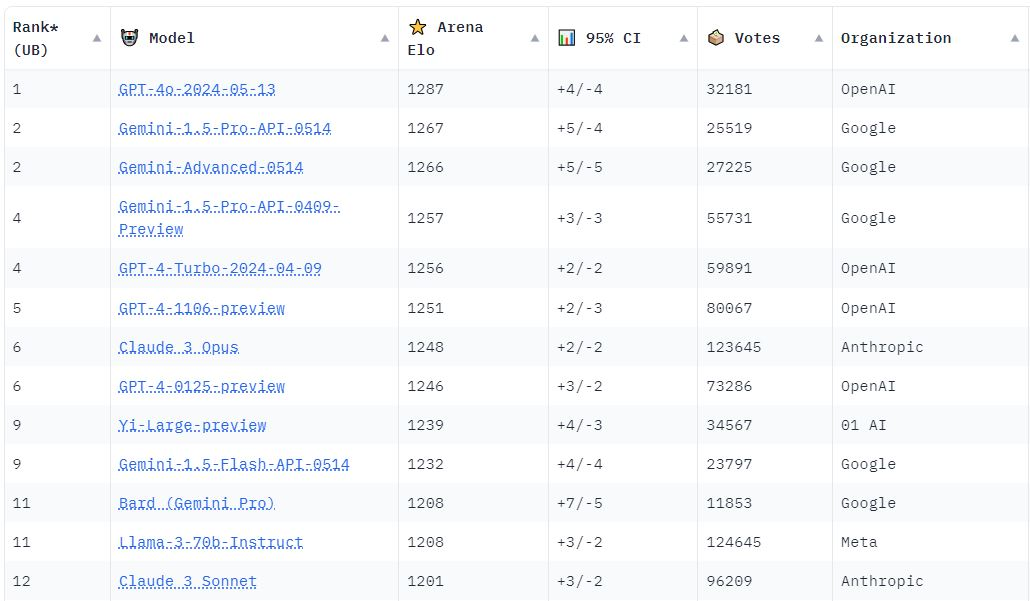  | 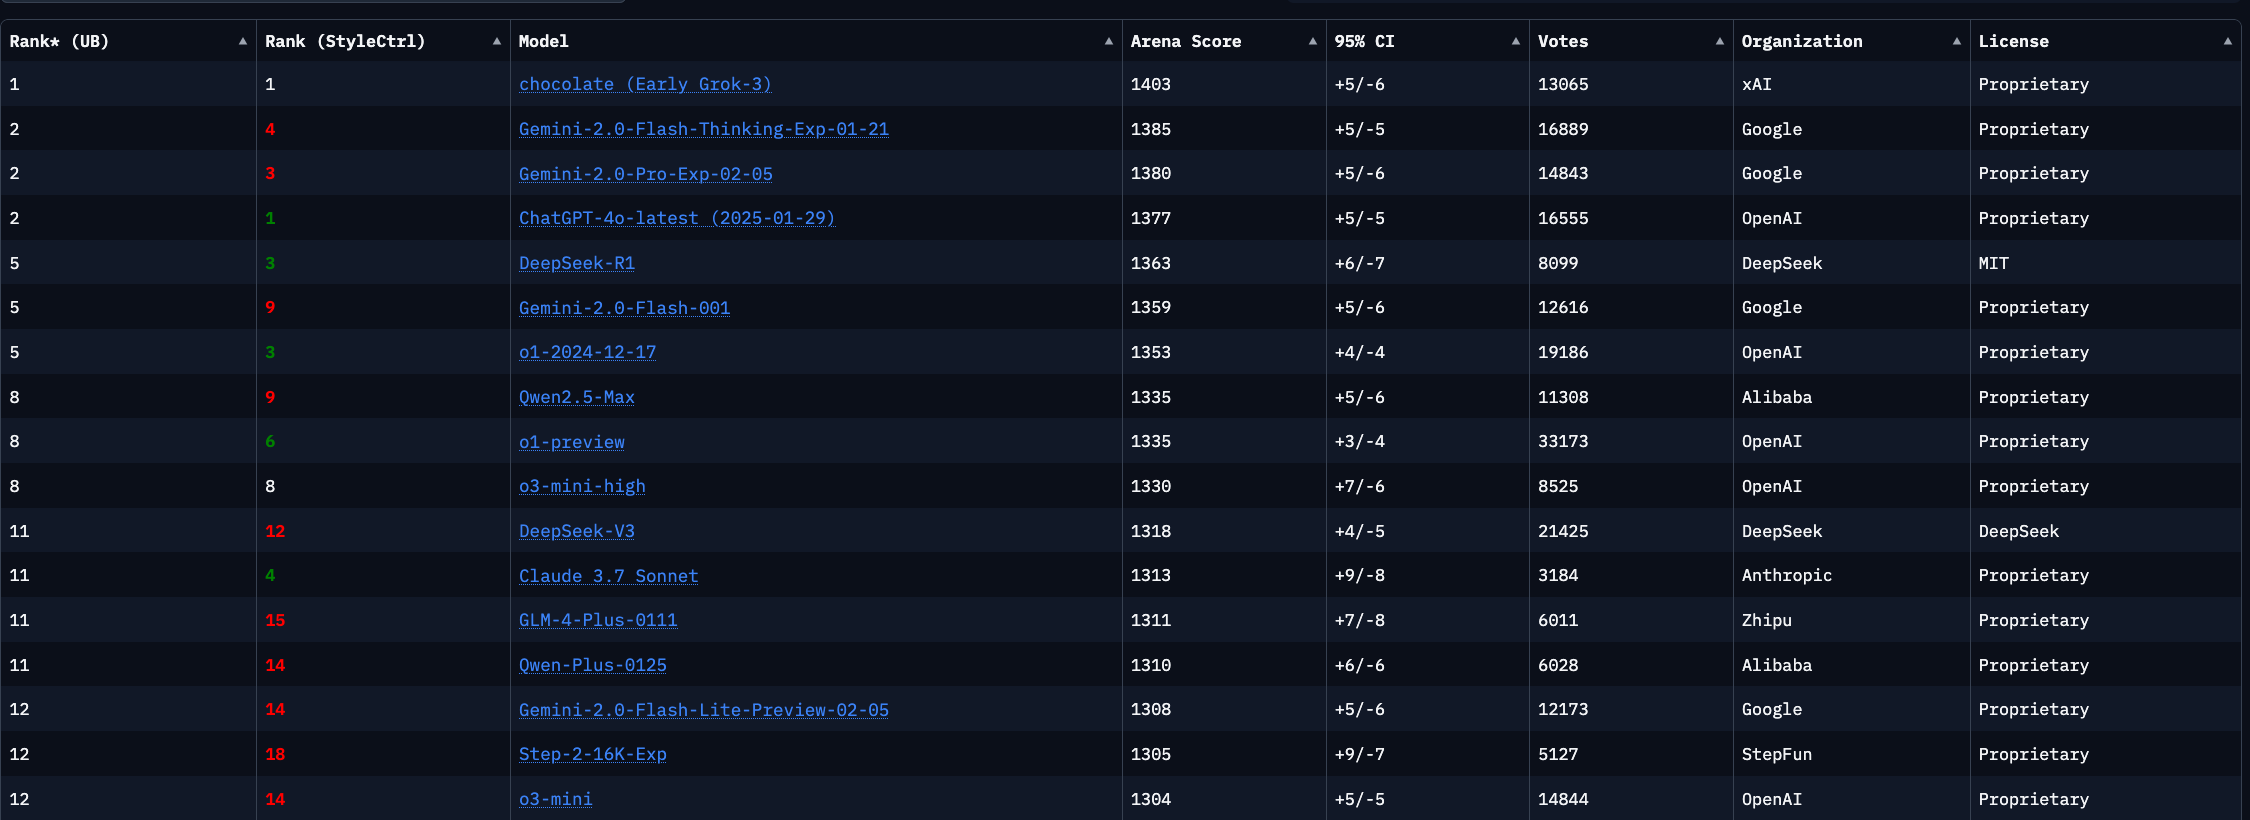  |




La disrupció de Grok i de Deepseek i la "caiguda" de Claude i de OpenAI. A OpenAI li han sortit nous competidors. També cap destacar la iteració continua de Gemini fins fer-lo un model competitiu a la altura dels altres. Esteim en un moment de màxima competitivitat, on s'estan prenent camins diferents: DeepSeek cerca la eficiència extrema mentre que GPT emplea la potència bruta sense control.

# 10. Provau alguns LLM que hi ha disponibles a través de la interfície de xat de HuggingFace i comentau les diferències que hi heu observat. Hi ha models recents com DeepSeek 3 i Grok 3?

Sí, hi ha aquests darrers models disponibles.

He realitzat una petita labor de investigació, ja que desconeixia HuggingFace. Pel que he pogut llegir, té molts de amants i molts de detractors, per diferent coses. Una de les coses que s'ha repetit en més de un post és que HuggingFace no deixa de ser una "capa" per damunt dels models, tant propietaris com lliures, així que afegeix complexitat i hi ha casos on el prompt-resposta no és el adequat, o hi ha casos on els entrenaments no són tan fructifers com el esperat. També he llegit queixes cobre el manejament del format o el contexte, que falla molts de vegades.